In [1]:
%matplotlib inline

import numpy as np
import warnings
warnings.filterwarnings('ignore')
from  tqdm import tqdm

import contextlib
@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally: 
        np.set_printoptions(**original)


In [2]:
import sys
sys.path.append("./src")

%load_ext autoreload
%autoreload 2
import wannier_loader 
import exchange_GG_2atoms

In [29]:
HighSymPointsNames = [ 'G', 'M', 'K', 'G']
# HighSymPointsDists = [0.        , 0.57736847, 0.91071231, 1.5774    ]
HighSymPointsDists = [0. , 0.97778934, 1.54231628, 2.67137017]


In [4]:
# read target kpath in integer units (see example)

kpath = []
kpath_draw = []
with open("./kpaths/kpath_integer.dat") as f:
        for line in f:
            hr_string = line.split()
            kpath.append([int(hr_string[1]), int(hr_string[2])])
            kpath_draw.append(float(hr_string[4]))
kpath = np.array(kpath)                

# $H_{m m'}(R)$

In [19]:
wannier_dir = './data/2layer/'
loader = wannier_loader.Wannier_loader_FM(wannier_dir)

nwa  22
Rpts 579
we have 2D hamiltonian
nwa  22
Rpts 579
we have 2D hamiltonian


In [20]:
nkpt = 24

loader.get_dense_hk(nkpt=nkpt)

100%|██████████| 576/576 [00:04<00:00, 128.80it/s]


In [21]:
hks = np.transpose(loader.hks_spins, (3, 2, 0, 1))
hk_mn_up = hks[0] 
hk_mn_dn = hks[1] 

In [22]:
hk_mn_up.shape

(576, 22, 22)

# Delta

In [23]:
dSarea = 1.0/(nkpt**2)
Delta = np.real(dSarea*np.sum(hk_mn_up - hk_mn_dn, axis=0 ))

assert np.linalg.norm(np.conj(Delta.T) - Delta) < 1e-9 , 'Delta is not hermitian'

dDelta = Delta[12:, 12:]
with printoptions(precision=2, suppress=True):
    print(dDelta)

DeltaBlock = np.array([
    [dDelta[:5, :5], dDelta[:5, 5:]],
    [dDelta[5:, :5], dDelta[5:, 5:]]
])
DeltaBlock.shape

[[-2.68  0.   -0.    0.   -0.    0.01  0.    0.   -0.   -0.  ]
 [ 0.   -1.99  0.    0.    0.4   0.   -0.   -0.    0.   -0.  ]
 [ 0.   -0.   -1.99  0.4   0.    0.   -0.   -0.   -0.    0.  ]
 [ 0.    0.    0.4  -2.37 -0.   -0.    0.   -0.   -0.    0.  ]
 [-0.    0.4   0.   -0.   -2.37 -0.   -0.    0.    0.   -0.  ]
 [ 0.01  0.   -0.   -0.   -0.   -2.68  0.   -0.    0.   -0.  ]
 [ 0.   -0.   -0.   -0.   -0.    0.   -1.99 -0.    0.    0.4 ]
 [ 0.   -0.   -0.   -0.   -0.   -0.    0.   -1.99  0.4   0.  ]
 [-0.   -0.   -0.   -0.   -0.    0.    0.    0.4  -2.37 -0.  ]
 [-0.   -0.   -0.   -0.   -0.   -0.    0.4   0.   -0.   -2.37]]


(2, 2, 5, 5)

In [25]:
with printoptions(precision=2, suppress=True):
    print(DeltaBlock)

[[[[-2.68  0.   -0.    0.   -0.  ]
   [ 0.   -1.99  0.    0.    0.4 ]
   [ 0.   -0.   -1.99  0.4   0.  ]
   [ 0.    0.    0.4  -2.37 -0.  ]
   [-0.    0.4   0.   -0.   -2.37]]

  [[ 0.01  0.    0.   -0.   -0.  ]
   [ 0.   -0.   -0.    0.   -0.  ]
   [ 0.   -0.   -0.   -0.    0.  ]
   [-0.    0.   -0.   -0.    0.  ]
   [-0.   -0.    0.    0.   -0.  ]]]


 [[[ 0.01  0.   -0.   -0.   -0.  ]
   [ 0.   -0.   -0.   -0.   -0.  ]
   [ 0.   -0.   -0.   -0.   -0.  ]
   [-0.   -0.   -0.   -0.   -0.  ]
   [-0.   -0.   -0.   -0.   -0.  ]]

  [[-2.68  0.   -0.    0.   -0.  ]
   [ 0.   -1.99 -0.    0.    0.4 ]
   [-0.    0.   -1.99  0.4   0.  ]
   [ 0.    0.    0.4  -2.37 -0.  ]
   [-0.    0.4   0.   -0.   -2.37]]]]


# J(q)

In [26]:
eF = -0.9745
beta = 18
n_iw = 200
S = 1.5 # spin

exchanges = exchange_GG_2atoms.Exchanges2(hk_mn_up, hk_mn_dn, DeltaBlock, S, eF, beta, n_iw)

100%|██████████| 576/576 [00:09<00:00, 59.40it/s]


J = 1477.46254+0.00000j meV


In [27]:
# calculate J(q) along kpath
J00, J01 = exchanges.getJpath(kpath)

100%|██████████| 25/25 [00:05<00:00,  4.73it/s]


J(Gamma) = 8.072 meV


100%|██████████| 25/25 [00:05<00:00,  4.69it/s]

J(Gamma) = 1.815 meV


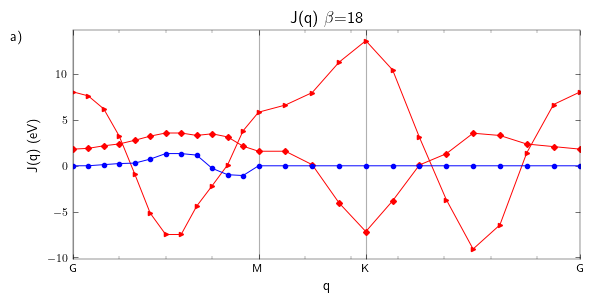

In [30]:
exchanges.plot( HighSymPointsDists, HighSymPointsNames, kpath_draw, saveQ=False)

# J(R)

In [31]:
# lattice vectors in A
a = np.array([[ 3.7600002707,  0.           , 0.          ],
              [-1.8800001353,  3.2562557526 , 0.          ],
              [ 0.          ,  0.           ,40.0000028793]])


vert = {}
num_vert=20
for i_index in range(-num_vert, num_vert):
    for j_index in range(-num_vert, num_vert):
        pair = [i_index, j_index]
        dist = np.round(np.linalg.norm(i_index*a[0] + j_index*a[1]), 2)
        if dist not in vert: 
            vert[dist]=[pair]
        else:
            vert[dist].append(pair)

# dist <-> [coords] in reciprocial vectors units
sorted_vert_J = dict(sorted(vert.items())[1:10])
print(sorted_vert_J)

#coords of neighbours
J_path = [ np.array(x)[:, np.newaxis] for y in list(sorted_vert_J.values()) for x in y]

tmp = [len(x)*[i+1]  for i, x in enumerate(list(sorted_vert_J.values()))]
J_path_plt = [ x for y in tmp for x in y] #list of neighbours orders

print('\n')
print(J_path_plt)
print(len(J_path_plt))

{3.76: [[-1, -1], [-1, 0], [0, -1], [0, 1], [1, 0], [1, 1]], 6.51: [[-2, -1], [-1, -2], [-1, 1], [1, -1], [1, 2], [2, 1]], 7.52: [[-2, -2], [-2, 0], [0, -2], [0, 2], [2, 0], [2, 2]], 9.95: [[-3, -2], [-3, -1], [-2, -3], [-2, 1], [-1, -3], [-1, 2], [1, -2], [1, 3], [2, -1], [2, 3], [3, 1], [3, 2]], 11.28: [[-3, -3], [-3, 0], [0, -3], [0, 3], [3, 0], [3, 3]], 13.03: [[-4, -2], [-2, -4], [-2, 2], [2, -2], [2, 4], [4, 2]], 13.56: [[-4, -3], [-4, -1], [-3, -4], [-3, 1], [-1, -4], [-1, 3], [1, -3], [1, 4], [3, -1], [3, 4], [4, 1], [4, 3]], 15.04: [[-4, -4], [-4, 0], [0, -4], [0, 4], [4, 0], [4, 4]], 16.39: [[-5, -3], [-5, -2], [-3, -5], [-3, 2], [-2, -5], [-2, 3], [2, -3], [2, 5], [3, -2], [3, 5], [5, 2], [5, 3]]}


[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
72


In [32]:
# calculate J(R) in neighbours list 
Js_neib00 =  np.array([ exchanges.calc_J(r.flatten(),0,0, 0) for r in tqdm(J_path)])
Js_neib01 =  np.array([ exchanges.calc_J(r.flatten(),0,1, 0) for r in tqdm(J_path)])

100%|██████████| 72/72 [00:03<00:00, 18.60it/s]



J00
	 #Neib   	 Sum J (meV)  	 J mean (meV)
--------------------------------------------------
                 6	                -6.02	                 -1.00                 
                 6	                11.61	                 1.94                 
                 6	                5.91	                 0.99                 
                 12	                -2.09	                 -0.17                 
                 6	                0.42	                 0.07                 
                 6	                -0.09	                 -0.01                 
                 12	                -0.65	                 -0.05                 
                 6	                -0.03	                 -0.00                 
                 12	                -1.43	                 -0.12                 
Total 7.63 (meV) FM

J01
	 #Neib   	 Sum J (meV)  	 J mean (meV)
--------------------------------------------------
                 6	                2.89	                 0.48

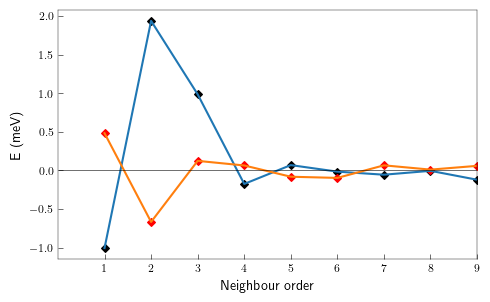

In [33]:
exchange_GG_2atoms.plotJ_Real(Js_neib00, Js_neib01, sorted_vert_J, J_path_plt)